In [1]:
%load_ext autoreload
%autoreload 2

### Static Mnist Video

A simple case where lstm cells are trained on a video whose frames are simply one static mnist digit which doesn't move.

In [2]:
from generate import *

/share/apps/python3/3.6.3/intel/lib/python3.6/site-packages/h5py-2.7.1-py3.6-linux-x86_64.egg/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz


In [3]:
time_steps=6
num_units=128
imsize=28
bsize=64

In [4]:
import tensorflow as tf
sess = tf.Session()

In [5]:
inputs = tf.placeholder(tf.float32, [None, time_steps, imsize, imsize])
labels = tf.placeholder(tf.float32, [None, 10])

# TODO: convolve?
flattened = tf.reshape(inputs, [-1, time_steps, imsize**2])
input_steps = tf.unstack(flattened, time_steps, 1)

In [6]:
from tensorflow.contrib import rnn

#defining the network
lstm_cell=rnn.BasicLSTMCell(num_units)
lstm_out, _ = rnn.static_rnn(lstm_cell,input_steps,dtype=tf.float32)

In [7]:
last_out = lstm_out[-1]
guesses = tf.layers.dense(last_out, 10)

digit_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=guesses,labels=labels))

digit_opt = tf.train.AdamOptimizer(learning_rate=0.001).minimize(digit_loss)

In [8]:
correct_prediction = tf.equal(tf.argmax(guesses,1), tf.argmax(labels,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [25]:
import numpy as np
import os, sys

MAX_ITER = 800
BATCH_SIZE=64
init=tf.global_variables_initializer()

sess.run(init)
epoch = 1
while epoch < MAX_ITER:
    batch_x, batch_y = mnist.train.next_batch(batch_size=BATCH_SIZE)

    batch_x = batch_x.reshape((BATCH_SIZE,imsize,imsize))
    
    static_series = np.stack([batch_x]*time_steps, axis=1)
#     print(static_series.shape, inputs.shape)
#     break

    sess.run(digit_opt, feed_dict={inputs: static_series, labels: batch_y})

    if epoch %10==0:
        acc = sess.run(accuracy,feed_dict={inputs:static_series,labels:batch_y})
        los = sess.run(digit_loss,feed_dict={inputs:static_series,labels:batch_y})
        sys.stdout.write('[%d/%d] L%.2f A%.2f\r' % (epoch, MAX_ITER, los, acc))
        sys.stdout.flush()

    epoch = epoch + 1
    
print()

# calculating test accuracy
test_data = mnist.test.images[:128].reshape((-1, imsize, imsize))
test_label = mnist.test.labels[:128]
static_series = np.stack([test_data]*time_steps, axis=1)
print("Testing Accuracy:", sess.run(accuracy, feed_dict={inputs: static_series, labels: test_label}))

[790/800] L0.26 A0.97
Testing Accuracy: 0.9921875


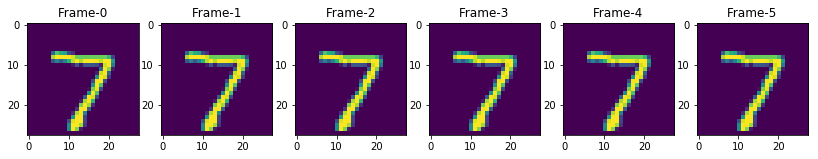

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
for ii in range(time_steps):
    plt.subplot(1, time_steps, ii+1)
    plt.gca().set_title('Frame-%d' % ii)
    plt.imshow(static_series[0, ii])
plt.show()